### 2-2  Loading  and preprocessing the data 

In [1]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

DIRECTORY_PATH = "./Wildfire Smoke.v1-raw.voc/"


import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F


class WildfireSmokeDataset(Dataset):
    def __init__(self, root, label_mapping, output_size=(256, 256), transforms=None):
        self.root = root
        self.output_size = output_size
        self.transforms = transforms
        self.label_mapping = label_mapping
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # Load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annotation_path = os.path.join(self.root, "annotations", self.annotations[idx])

        img = Image.open(img_path)
        orig_width, orig_height = img.size
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            label = label_mapping.get(label, 0)
            labels.append(label)
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            xmin = (xmin / orig_width) * self.output_size[0]
            xmax = (xmax / orig_width) * self.output_size[0]
            ymin = (ymin / orig_height) * self.output_size[1]
            ymax = (ymax / orig_height) * self.output_size[1]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(obj),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        new_img = F.resize(img, self.output_size)
        return new_img, target

    def __len__(self):
        return len(self.imgs)


# Usage:
label_mapping = {"smoke": 1}
dataset = WildfireSmokeDataset(
    root= DIRECTORY_PATH + "/train",
    output_size=(224, 224),
    label_mapping=label_mapping,
    transforms=ToTensor(),
)
validation_dataset = WildfireSmokeDataset(
    root= DIRECTORY_PATH + "/valid",
    output_size=(224, 224),
    label_mapping=label_mapping,
    transforms=ToTensor(),
)
test_dataset = WildfireSmokeDataset(
    root= DIRECTORY_PATH + "/test",
    output_size=(224, 224),
    label_mapping=label_mapping,
    transforms=ToTensor(),
)
train_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4
)
test_data_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=4, shuffle=False, num_workers=4
)
val_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=4
)

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def show_sample(idx):
    fig, ax = plt.subplots(1)
    ax.imshow(dataset[idx][0].permute(1, 2, 0))
    x_min = dataset[idx][1]['boxes'][0][0].item() 
    x_max = dataset[idx][1]['boxes'][0][2].item()
    y_min = dataset[idx][1]['boxes'][0][1].item()
    y_max = dataset[idx][1]['boxes'][0][3].item()
    print(x_min,x_max,y_min,y_max)
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

/home/syntheticdemon/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def show_sample_test(box, real_target, image):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))
    x_min = box[0]
    x_max = box[2]
    y_min = box[1]
    y_max = box[3]
    print(real_target)
    x_min_t = real_target[0]
    x_max_t = real_target[2]
    y_min_t = real_target[1]
    y_max_t = real_target[3]
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(rect)
    rect = patches.Rectangle(
        (x_min_t, y_min_t),
        x_max_t - x_min_t,
        y_max_t - y_min_t,
        linewidth=1,
        edgecolor="b",
        facecolor="none",
    )
    ax.add_patch(rect)
    plt.show()

/home/syntheticdemon/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


109.55000305175781 205.8000030517578 68.5999984741211 124.13333129882812
75.5999984741211 105.69999694824219 93.33333587646484 112.0
175.0 215.25 98.93333435058594 133.0
69.30000305175781 75.25 96.5999984741211 107.80000305175781
57.75 72.80000305175781 120.4000015258789 130.1999969482422


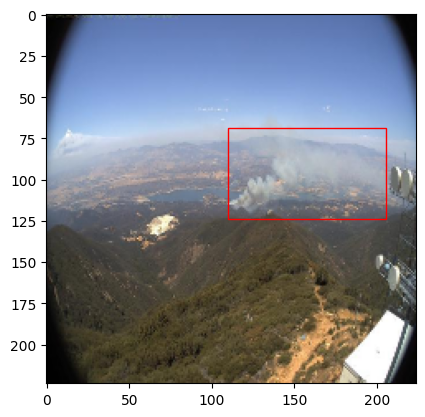

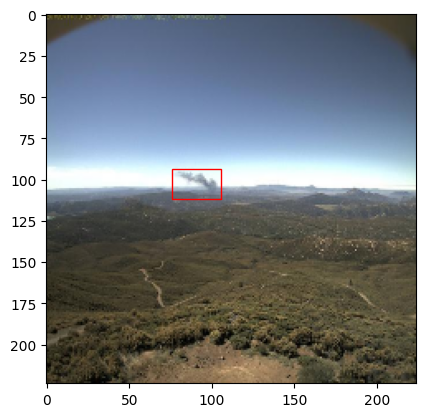

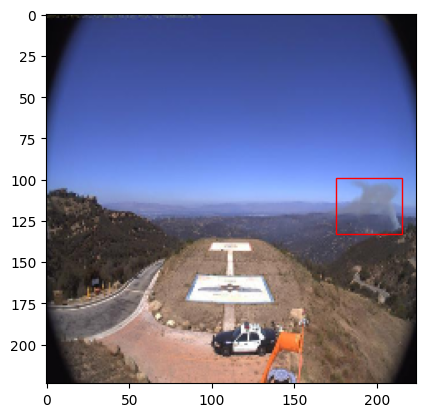

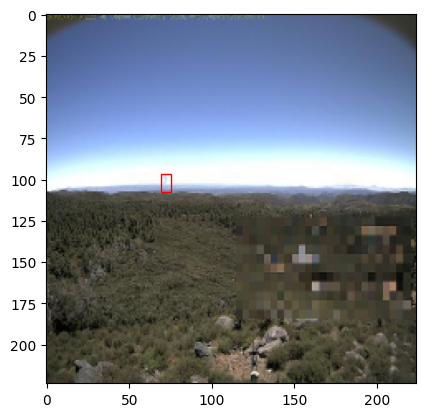

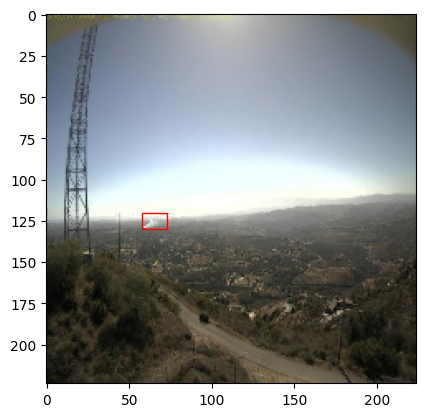

In [4]:
for i in range(5,10):
    show_sample(i)

In [6]:
import torchvision
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim

# load a pre-trained model for classification and return
# only the features
backbone = models.vgg16(pretrained=True).features
for layer in backbone[:10]:
    for p in layer.parameters():
        p.requires_grad = False


# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 512

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
)

# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=7,
    sampling_ratio=2,
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)

/home/syntheticdemon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syntheticdemon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

num_epochs = 35  # Number of training epochs

device= "cuda"
def faster_rcnn_loss(class_logits, box_regression, labels, regression_targets):
    # Classification loss (Cross-Entropy)
    classification_loss = F.cross_entropy(class_logits, labels)

    # Only consider positive samples for regression loss
    pos_mask = torch.where(labels > 0)[0]

    # Regression loss (Smooth L1 Loss)
    regression_loss = F.smooth_l1_loss(
        box_regression[pos_mask], regression_targets[pos_mask]
    )

    return classification_loss, regression_loss


device = torch.device(device if torch.cuda.is_available() else "cpu")
model.to(device)
device = torch.device(device if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
from tqdm import tqdm
history = {"train": [],"val": []}

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    total_epoch = 0
    print(f"-------------epoch{epoch}---------")
    for images, targets in tqdm(train_data_loader, desc=f'Epoch {epoch+1}'):
        images = images.to(device)
        regression_targets = targets["boxes"].to(device)
        labels = targets["labels"].to(device)
        labels = labels.to(torch.int64)
        zipped = zip(regression_targets, labels)
        targets_real = [{"labels": labels, "boxes": boxes} for boxes, labels in zipped]
        # print(targets_real)
        model_output = model(images, targets_real)
#         print(model_output)
        # Combine the losses
        total_loss = model_output['loss_classifier'] + model_output['loss_box_reg'] 

        # Backward pass and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        total_epoch += total_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_Loss: {total_epoch/len(train_data_loader)}")
    history["train"].append(total_epoch/len(train_data_loader))
    total_val_loss = 0
    total_loss = 0 
    # validaition:
#     model.train()
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = images.to(device)
            regression_targets = targets["boxes"].to(device)
            labels = targets["labels"].to(device)
            labels = labels.to(torch.int64)
            zipped = zip(regression_targets, labels)
            targets_real = [{"labels": labels, "boxes": boxes} for boxes, labels in zipped]
            # print(targets_real)
            model_output = model(images, targets_real)
#             print(model_output)
            # Combine the losses
            total_loss = model_output['loss_classifier'] + model_output['loss_box_reg'] 
            total_val_loss += total_loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Val_Loss: {total_val_loss/len(val_data_loader)}")
        history["val"].append(total_val_loss/len(val_data_loader))
        


-------------epoch0---------


Epoch 1: 100%|██████████| 129/129 [00:55<00:00,  2.33it/s]

Epoch [1/35], Train_Loss: 0.062362122594905915


Epoch [1/35], Val_Loss: 0.021734264238100303
-------------epoch1---------


Epoch 2: 100%|██████████| 129/129 [00:50<00:00,  2.55it/s]

Epoch [2/35], Train_Loss: 0.018648092548341252


Epoch [2/35], Val_Loss: 0.020056824052804394
-------------epoch2---------


Epoch 3: 100%|██████████| 129/129 [00:50<00:00,  2.53it/s]

Epoch [3/35], Train_Loss: 0.016009820964505043


Epoch [3/35], Val_Loss: 0.020664626389349763
-------------epoch3---------


Epoch 4: 100%|██████████| 129/129 [00:50<00:00,  2.53it/s]

Epoch [4/35], Train_Loss: 0.017027464059954003


Epoch [4/35], Val_Loss: 0.020848647691309452
-------------epoch4---------


Epoch 5: 100%|██████████| 129/129 [00:50<00:00,  2.53it/s]

Epoch [5/35], Train_Loss: 0.019367348882838968


Epoch [5/35], Val_Loss: 0.022991499998361656
-------------epoch5---------


Epoch 6: 100%|██████████| 129/129 [00:50<00:00,  2.53it/s]

Epoch [6/35], Train_Loss: 0.019726552863338197


Epoch [6/35], Val_Loss: 0.021072785664153725
-------------epoch6---------


Epoch 7: 100%|██████████| 129/129 [00:50<00:00,  2.53it/s]

Epoch [7/35], Train_Loss: 0.017925852346558902


Epoch [7/35], Val_Loss: 0.01779288576768809
-------------epoch7---------


Epoch 8: 100%|██████████| 129/129 [00:50<00:00,  2.53it/s]

Epoch [8/35], Train_Loss: 0.015020813711723962


Epoch [8/35], Val_Loss: 0.015089617797026509
-------------epoch8---------


Epoch 9: 100%|██████████| 129/129 [00:51<00:00,  2.52it/s]

Epoch [9/35], Train_Loss: 0.012897542686844173


Epoch [9/35], Val_Loss: 0.013287744521604557
-------------epoch9---------


Epoch 10: 100%|██████████| 129/129 [00:51<00:00,  2.52it/s]

Epoch [10/35], Train_Loss: 0.011666768204778173


Epoch [10/35], Val_Loss: 0.01359199991719307
-------------epoch10---------


Epoch 11: 100%|██████████| 129/129 [00:51<00:00,  2.52it/s]

Epoch [11/35], Train_Loss: 0.011295246957555818


Epoch [11/35], Val_Loss: 0.011946610983853278
-------------epoch11---------


Epoch 12: 100%|██████████| 129/129 [00:51<00:00,  2.52it/s]

Epoch [12/35], Train_Loss: 0.010557384054219826


Epoch [12/35], Val_Loss: 0.012603122826763674
-------------epoch12---------


Epoch 13: 100%|██████████| 129/129 [00:51<00:00,  2.52it/s]

Epoch [13/35], Train_Loss: 0.010052104216148399


Epoch [13/35], Val_Loss: 0.01190890404885929
-------------epoch13---------


Epoch 14: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [14/35], Train_Loss: 0.009969801124448837


Epoch [14/35], Val_Loss: 0.012284989395227871
-------------epoch14---------


Epoch 15: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [15/35], Train_Loss: 0.009747023959535845


Epoch [15/35], Val_Loss: 0.012153594607585355
-------------epoch15---------


Epoch 16: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [16/35], Train_Loss: 0.008977075667813594


Epoch [16/35], Val_Loss: 0.011357683761927643
-------------epoch16---------


Epoch 17: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [17/35], Train_Loss: 0.008814576198346913


Epoch [17/35], Val_Loss: 0.010432802545102803
-------------epoch17---------


Epoch 18: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [18/35], Train_Loss: 0.008283362756374963


Epoch [18/35], Val_Loss: 0.009796011488345501
-------------epoch18---------


Epoch 19: 100%|██████████| 129/129 [00:51<00:00,  2.52it/s]

Epoch [19/35], Train_Loss: 0.0076840964404057506


Epoch [19/35], Val_Loss: 0.010039068439877346
-------------epoch19---------


Epoch 20: 100%|██████████| 129/129 [00:51<00:00,  2.52it/s]

Epoch [20/35], Train_Loss: 0.007924375168495458


Epoch [20/35], Val_Loss: 0.009165444864744418
-------------epoch20---------


Epoch 21: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [21/35], Train_Loss: 0.00732214757883849


Epoch [21/35], Val_Loss: 0.010506950625169435
-------------epoch21---------


Epoch 22: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [22/35], Train_Loss: 0.007257091136858618


Epoch [22/35], Val_Loss: 0.009062677989468762
-------------epoch22---------


Epoch 23: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [23/35], Train_Loss: 0.006974432186959961


Epoch [23/35], Val_Loss: 0.009213805970686832
-------------epoch23---------


Epoch 24: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [24/35], Train_Loss: 0.007108252959383666


Epoch [24/35], Val_Loss: 0.01055476190767398
-------------epoch24---------


Epoch 25: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [25/35], Train_Loss: 0.007195623365028711


Epoch [25/35], Val_Loss: 0.010393653420339289
-------------epoch25---------


Epoch 26: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [26/35], Train_Loss: 0.006820040501838247


Epoch [26/35], Val_Loss: 0.009369473548998175
-------------epoch26---------


Epoch 27: 100%|██████████| 129/129 [00:51<00:00,  2.50it/s]

Epoch [27/35], Train_Loss: 0.006909653020557016


Epoch [27/35], Val_Loss: 0.010524013281897887
-------------epoch27---------


Epoch 28: 100%|██████████| 129/129 [00:51<00:00,  2.50it/s]

Epoch [28/35], Train_Loss: 0.006135695440200151


Epoch [28/35], Val_Loss: 0.010114728375092932
-------------epoch28---------


Epoch 29: 100%|██████████| 129/129 [00:51<00:00,  2.50it/s]

Epoch [29/35], Train_Loss: 0.006553241471370119


Epoch [29/35], Val_Loss: 0.009564738794180908
-------------epoch29---------


Epoch 30: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [30/35], Train_Loss: 0.006293915468448585


Epoch [30/35], Val_Loss: 0.00971431069468197
-------------epoch30---------


Epoch 31: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [31/35], Train_Loss: 0.006074259518564484


Epoch [31/35], Val_Loss: 0.009719888195640555
-------------epoch31---------


Epoch 32: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [32/35], Train_Loss: 0.006035725358700336


Epoch [32/35], Val_Loss: 0.01057527307420969
-------------epoch32---------


Epoch 33: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [33/35], Train_Loss: 0.005637902370293069


Epoch [33/35], Val_Loss: 0.009615460239154728
-------------epoch33---------


Epoch 34: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [34/35], Train_Loss: 0.0059993792629382


Epoch [34/35], Val_Loss: 0.00965478907241241
-------------epoch34---------


Epoch 35: 100%|██████████| 129/129 [00:51<00:00,  2.51it/s]

Epoch [35/35], Train_Loss: 0.0054787928768697145


Epoch [35/35], Val_Loss: 0.008924793641965249


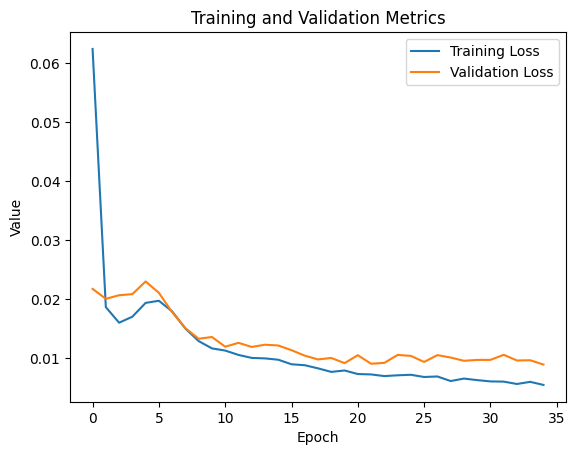

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(range(epoch+1), history['train'], label = 'Training Loss')
plt.plot(range(epoch+1), (history["val"]), label = 'Validation Loss')
# Adding legends
plt.legend()

# Optionally, you can add labels for the x-axis and y-axis and a title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')

plt.show()

tensor([138.9500,  98.9333, 172.9000, 113.8667])


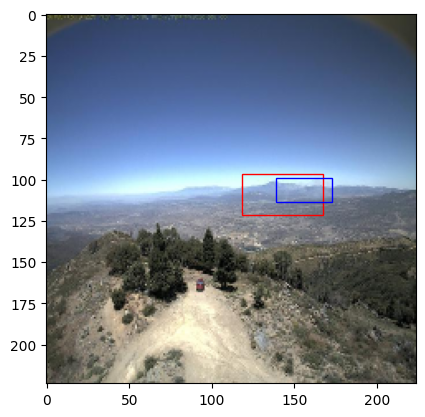

tensor([124.6000, 124.1333, 141.4000, 141.4000])


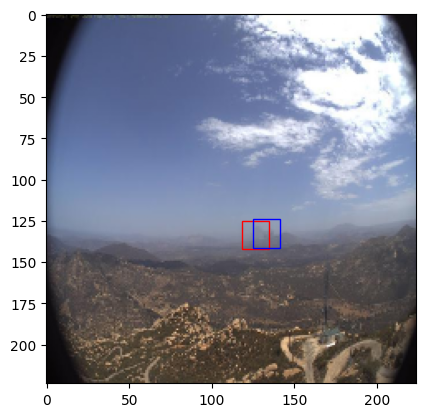

tensor([ 32.9000, 103.1333,  93.8000, 124.1333])


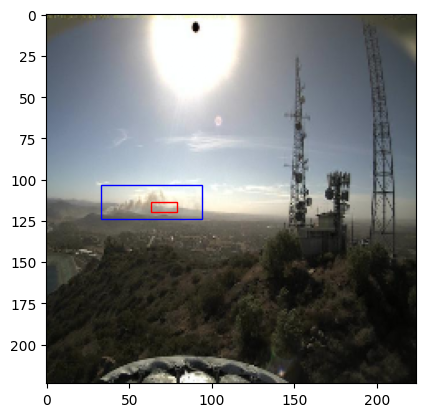

No Bounding Box generated
tensor([  0.3500,  87.2667,  53.5500, 155.4000])


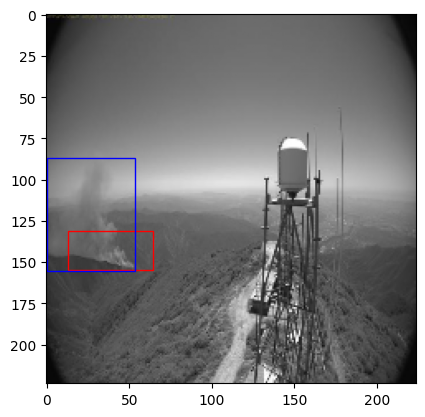

tensor([114.8000,  96.6000, 172.9000, 117.6000])


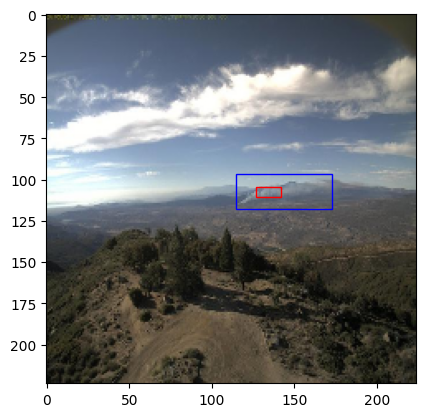

tensor([ 74.5500,  93.3333, 104.6500, 109.6667])


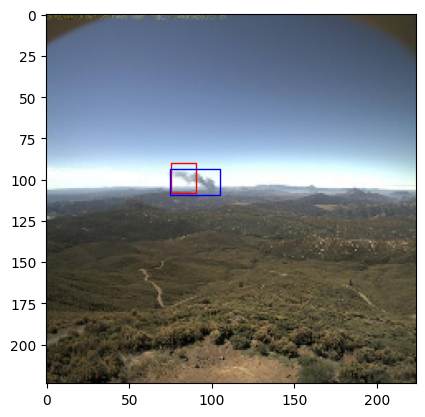

tensor([ 69.6500,  93.8000, 103.6000, 108.2667])


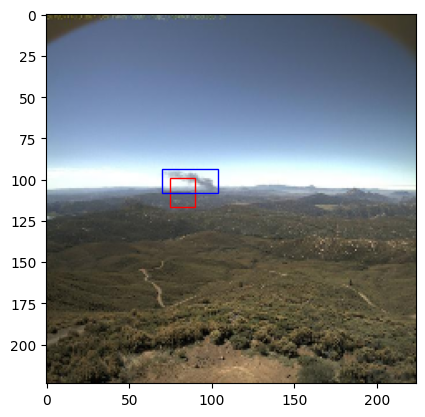

tensor([147.3500,  91.0000, 191.1000, 115.2667])


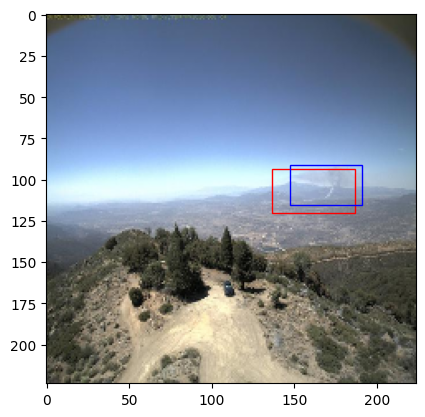

tensor([ 47.2500,  92.8667,  61.9500, 133.4667])


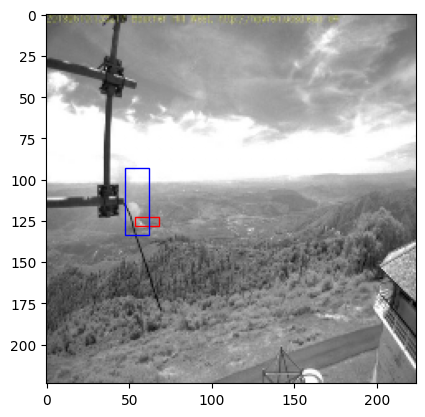

tensor([ 33.2500,  95.6667, 128.4500, 124.6000])


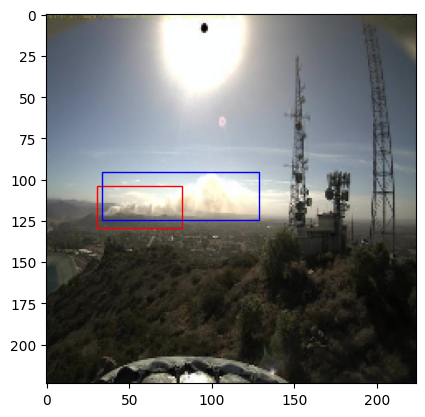

tensor([ 86.8000,  99.8667, 146.6500, 146.5333])


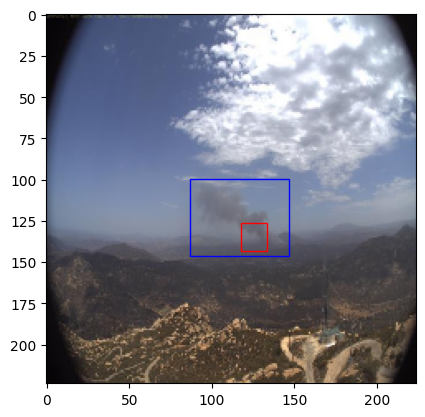

KeyboardInterrupt: 

In [10]:
with torch.no_grad():  # Disable gradient computation
    x=0
    for data, target in test_data_loader:
        regression_targets = target["boxes"].to("cpu")
        labels = target["labels"].to("cpu")
        labels = labels.to(torch.int64).to("cpu")
        zipped = zip(regression_targets, labels)
        targets_real = [{"labels": labels, "boxes": boxes} for boxes, labels in zipped]
        outputs = model(data.to("cpu"), targets_real)
        for bbox, image, real_target in zip(outputs, data, target["boxes"]):
            if len(bbox["boxes"]) != 0:
                show_sample_test(bbox["boxes"][0].cpu(), real_target[0], image.cpu())
            else:
                print("No Bounding Box generated")
        x =x  + 1
        if (x == 5):
            break
        